In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import orca
import time
import geopandas as gpd

In [3]:
hdf = pd.HDFStore('output/pipeline.h5')
pp = hdf['/persons/trip_mode_choice']
hh = hdf['/households/trip_mode_choice']
tours = hdf['/tours/trip_mode_choice']
trips = hdf['/trips/trip_mode_choice']

print ('Number of Households: ',hh.shape[0])
print ('Number of Persons: ',pp.shape[0])
print ('Number of tours: ',tours.shape[0])
print ('Number of trips: ',trips.shape[0])

Number of Households:  666970
Number of Persons:  1657301
Number of tours:  2223057
Number of trips:  5695513


In [4]:
def car_ownership_validation(hh):
    ''' Validation tool for car ownership model
    Input: Dataframe with columns VEHCL: Real number of vehicles, 
           and 'auto_ownership': predicted household car ownership. 
    Output: Plots of carownership by TAZ. 
    '''
    # Auto ownership by TAZ 
    hh['0'] = hh['auto_ownership'] == 0
    hh['1'] = hh['auto_ownership'] == 1
    hh['2'] = hh['auto_ownership'] == 2
    hh['3'] = hh['auto_ownership'] == 3
    hh['4'] = hh['auto_ownership'] == 4

    auto_asim = hh.groupby('TAZ').agg({'0': 'sum','1': 'sum','2': 'sum','3': 'sum','4': 'sum' })
    auto_asim.reset_index(inplace = True)

    auto_asim = pd.melt(auto_asim, id_vars=['TAZ'], value_vars=['0', '1', '2', '3', '4'])
    
    #VEHCL by TAZ 
    hh['0'] = hh['VEHICL'] == 0
    hh['1'] = hh['VEHICL'] == 1
    hh['2'] = hh['VEHICL'] == 2
    hh['3'] = hh['VEHICL'] == 3
    hh['4'] = hh['VEHICL'] >= 4

    auto_tm1 = hh.groupby('TAZ').agg({'0': 'sum','1': 'sum','2': 'sum','3': 'sum','4': 'sum', })
    auto_tm1.reset_index(inplace = True)

    auto_tm1 = pd.melt(auto_tm1, id_vars=['TAZ'], value_vars=['0', '1', '2', '3', '4'])
    
    # Merge ativitysim and validation results in one table
    auto = auto_asim.merge(auto_tm1, how = 'inner', on = ['TAZ', 'variable'], suffixes=('_asim', '_tm1'))
    auto.columns = ['TAZ', 'Auto ownership', 'ActivitySim', 'True value']
    
    #Plot
    g = sns.lmplot('True value','ActivitySim', auto,col = 'Auto ownership',sharex = False,sharey = False,
               markers='o', height=5, aspect=0.8, x_jitter=.1, col_wrap=3,
              scatter_kws={"s": 20, "edgecolor": 'k', "alpha": 0.5})

    g.fig.suptitle("H3-to-H3 Car ownerwhip \n ActivitySim", y=1.05, fontsize = 15);
    return auto

## Work Distances LODES

In [9]:
#Data
zones = gpd.read_file('data/h3_hexbis.shp', crs = 'EPSG: 4326')
zones = zones.to_crs(crs= 'epsg:2768')
zones['centroid'] = zones.geometry.centroid

url = 's3://austin-activitysim/base/tx_od_main_JT01_2015.csv'
lodes = pd.read_csv(url, dtype={'w_geocode': str, 'h_geocode': str}, 
                        usecols=['w_geocode', 'h_geocode', 'S000'])

blocks = pd.read_csv('data/blocks.csv', dtype = {'TAZ': int, 'block_id': str})

In [10]:
#H3 to H3 Distance
tours_ods = tours.merge(zones[['TAZ', 'centroid']], how = 'left', 
            left_on = 'origin', right_on = 'TAZ').merge(\
            zones[['TAZ', 'centroid']], how = 'left', 
            left_on = 'destination', right_on = 'TAZ', suffixes=('_h', '_w'))

tours_ods['distance_m'] = gpd.GeoSeries(tours_ods['centroid_h']).\
                          distance(gpd.GeoSeries(tours_ods['centroid_w']))  

In [11]:
# LODES - Distances 
lodes_ods = lodes.merge(blocks[['block_id', 'TAZ']], 
                how = 'inner', left_on = 'w_geocode', right_on = 'block_id').\
                merge(blocks[['block_id', 'TAZ']], 
                      how = 'inner', left_on = 'h_geocode', right_on = 'block_id',
                      suffixes=('_w', '_h'))

lodes_ods = lodes_ods.merge(zones[['TAZ', 'centroid']], how = 'left', 
            left_on = 'TAZ_w', right_on = 'TAZ').merge(\
            zones[['TAZ', 'centroid']], how = 'left', 
            left_on = 'TAZ_h', right_on = 'TAZ', suffixes=('_w', '_h'))

lodes_ods['distance_m'] = gpd.GeoSeries(lodes_ods['centroid_h']).\
                          distance(gpd.GeoSeries(lodes_ods['centroid_w']))  

#Repeat rows with S000 > 1 
reps = [val for val in lodes_ods.S000]
lodes_ods = lodes_ods.loc[np.repeat(lodes_ods.index.values, reps)]

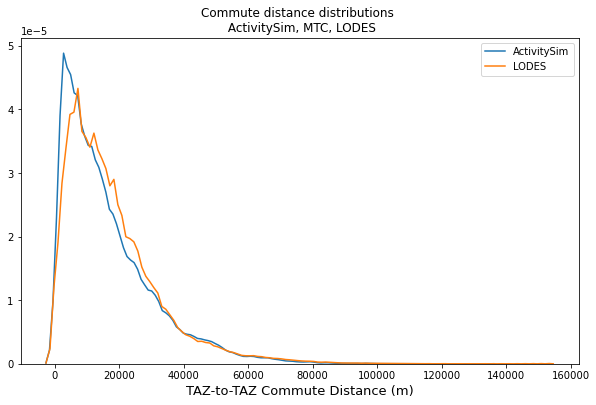

In [12]:
work_mask_as = tours_ods.tour_type == 'work'

fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(tours_ods[work_mask_as]['distance_m'],ax=ax, label='ActivitySim')
sns.kdeplot(lodes_ods['distance_m'], ax=ax, label='LODES')
ax.set_xlabel('TAZ-to-TAZ Commute Distance (m)', fontsize=13)
plt.title('Commute distance distributions \n ActivitySim, MTC, LODES');

# Mode choice 

## Work trips

In [13]:
path = 's3://austin-activitysim/base/A302103 - Means of transportation (18) (Workers 16 years and over).csv'
ctpp_ms = pd.read_csv(path)

In [14]:
modes_ctpp = {'Car, truck, or van -- Drove alone': 'Car',
         'Car, truck, or van -- In a 2-person carpool': 'Car',
         'Car, truck, or van -- In a 3-person carpool': 'Car',
         'Car, truck, or van -- In a 4-person carpool': 'Car',
         'Car, truck, or van -- In a 5-or-6-person carpool': 'Car',
         'Car, truck, or van -- In a 7-or-more-person carpool': 'Car',
         'Bus or trolley bus': 'Bus', 
         'Streetcar or trolley car': 'Bus',
         'Subway or elevated': 'heavy rail', 
         'Railroad' : 'other', 
         'Ferryboat': 'other', 
         'Bicycle': 'Bike', 
         'Walked': 'Walk',
         'Taxicab': 'other',
         'Motorcycle': 'other',
         'Other method':'other'}

ctpp_ms['ctpp_mode'] = ctpp_ms['Means of Transportation 18'].replace(modes_ctpp)
ctpp_ms.dropna(inplace = True)
ctpp_ms['Workers 16 and Over'] = ctpp_ms['Workers 16 and Over'].astype(int)

mode_share_ctpp = ctpp_ms.groupby('ctpp_mode').sum()
mode_share_ctpp.reset_index(inplace = True)
mask_mode = ~mode_share_ctpp.ctpp_mode.isin(['Auto','Total, means of transportation', 'Worked at home'])
mode_share_ctpp = mode_share_ctpp[mask_mode]
mode_share_ctpp['suma'] = mode_share_ctpp['Workers 16 and Over'].sum()
mode_share_ctpp['mode_share'] = mode_share_ctpp['Workers 16 and Over']/mode_share_ctpp['suma']

In [15]:
modes_asim = {'WALK_LRF': 'other', 
              'WALK_LOC': 'Bus', 
              'SHARED3FREE': 'Car', 
              'WALK_COM': 'other',
              'DRIVEALONEFREE': 'Car', 
              'SHARED2FREE':'Car', 
              'BIKE': 'Bike', 
              'DRIVE_LRF': 'other',
              'WALK': 'Walk',
              'WALK_HVY':'heavy rail', 
              'WALK_EXP':'Bus', 
              'DRIVE_LOC': 'Bus', 
              'DRIVE_HVY':'heavy rail', 
              'DRIVE_COM':'other',
              'DRIVEALONEPAY':'Car', 
              'SHARED2PAY':'Car', 
              'DRIVE_EXP': 'Bus',
              'SHARED3PAY':'Car'}

tours['ctpp_mode'] = tours.tour_mode.replace(modes_asim)
tours_work = tours[tours.tour_type == 'work'] # just work trips

mode_share_asim_work = pd.DataFrame(tours_work.groupby('ctpp_mode')['person_id'].count())
mode_share_asim_work['suma'] = mode_share_asim_work['person_id'].sum()
mode_share_asim_work['mode_share'] = mode_share_asim_work['person_id']/mode_share_asim_work['suma'] 
mode_share_asim_work.reset_index(inplace = True)

In [16]:
mode_share_asim_work['model'] = 'Activity Sim'
mode_share_ctpp['model'] = 'CTPP'
join = pd.concat([mode_share_asim_work, mode_share_ctpp])

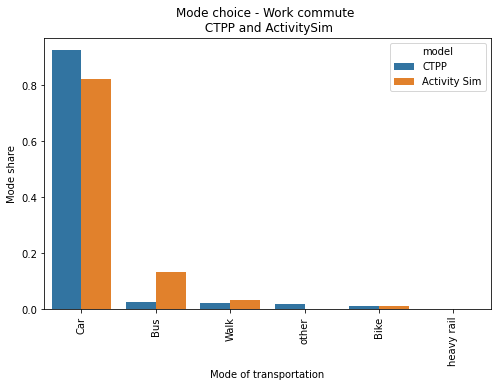

In [17]:
fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x='ctpp_mode', y='mode_share', hue = 'model', data = join.sort_values('mode_share', ascending=False))
plt.xticks(rotation = 90)
plt.title('Mode choice - Work commute \n CTPP and ActivitySim')
plt.ylabel('Mode share')
plt.xlabel('Mode of transportation');

## All trips

In [18]:
modes_asim = {'WALK_LRF': 'walk_transit', 
              'WALK_LOC': 'walk_transit', 
              'SHARED3FREE': 'car', 
              'WALK_COM': 'walk_transit',
              'DRIVEALONEFREE': 'car', 
              'SHARED2FREE':'car', 
              'BIKE': 'bike', 
              'DRIVE_LRF': 'drive_transit',
              'WALK': 'walk',
              'WALK_HVY':'walk_transit', 
              'WALK_EXP':'walk_transit', 
              'DRIVE_LOC': 'drive_transit', 
              'DRIVE_HVY':'drive_transit', 
              'DRIVE_COM':'drive_transit',
              'DRIVEALONEPAY':'car', 
              'SHARED2PAY':'car', 
              'DRIVE_EXP': 'drive_transit',
              'SHARED3PAY':'car'}

tours['asim_mode'] = tours.tour_mode.replace(modes_asim)

mode_share_asim = pd.DataFrame(tours.groupby('asim_mode')['person_id'].count())
mode_share_asim['total'] = mode_share_asim['person_id'].sum()
mode_share_asim['mode_share'] = mode_share_asim['person_id']/mode_share_asim['total'] 
mode_share_asim.reset_index(inplace = True)

In [19]:
def mode_choice_validation(tour_mode):
    ''' Validate mode shares'''
    
    #Results activitysim 
    pct = tour_mode.value_counts()/tour_mode.count()
    asim = pd.DataFrame(pct).reset_index()
    asim.columns = ['mode', 'share']
    asim['model'] = 'ActivitySim'
    
    # Real values
#     real_shares = pd.DataFrame({'mode':['car', 'walk', 'bike', 'ride_hail', 
#                        'ride_hail_transit', 'walk_transit', 
#                        'drive_transit', 'ride_hail_pooled'], 
#                       'share': [0.8455, 0.0868, 0.0125, 0.0113,
#                              0.0019, 0.0329, 0.0035, 0.0056] })
    #assuming: Raid_hail options: car. and ride_hail_transit == drive)_transit
    real_shares = pd.DataFrame({'mode':['car', 'walk', 'bike', 'walk_transit', 'drive_transit'], 
                      'share': [0.8624, 0.0868, 0.0125, 0.0329, 0.0054] })
    assert real_shares.share.sum() == 1
    real_shares['model'] = 'Real mode share'
    
    
    results = pd.concat((asim,real_shares), axis = 0)
    
    #plotting 
    fig, ax = plt.subplots(figsize = (8,5))
    sns.barplot(x='mode', y='share', hue = 'model', data = results.sort_values('share', ascending=False))
    plt.xticks(rotation = 90)
    plt.title('Mode choice - Mode shares')
    plt.ylabel('Mode share - log Scale')
    plt.xlabel('Mode of transportation')
#     plt.yscale('log')
    plt.legend(loc = 'upper right')
    return asim;

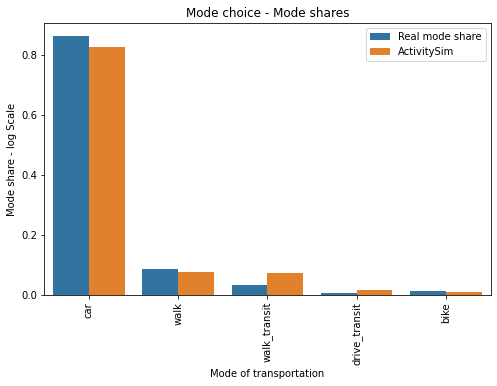

In [20]:
asim = mode_choice_validation(tour_mode = tours['asim_mode'])

In [21]:
# +- 20% travel time increased
modes = ['car', 'walk_transit', 'walk', 'bike','drive_transit', ]
shares = [0.84583289, 0.08093849, 0.04848146, 0.01141363,0.01333353, ]

#modify 20% of ASC for walk_transit and drive_transit
modes = ['car', 'walk_transit', 'walk', 'bike', 'drive_transit']
shares2 = [0.8562877 , 0.06890088, 0.0508367 , 0.01216876, 0.01180596]

#+20% asc for walking 
modes =['car', 'walk_transit', 'walk', 'drive_transit', 'bike']
shares3 =[0.85274868, 0.06670294, 0.05713508, 0.01175955, 0.01165374]

#Changing nesting parameters
modes =['car', 'walk_transit', 'walk', 'bike', 'drive_transit']
shares3 =[0.8549406 , 0.06613669, 0.05700813, 0.01193967, 0.00997491]

In [22]:
# def plot_tour_mode_share(tour_mode):
#     pct = tour_mode.value_counts()/tour_mode.count()
#     plt.bar(pct.index, pct)
#     plt.xticks(rotation = 90);

# plot_tour_mode_share(tours['asim_mode'])

## Car ownership 

In [23]:
hh.VEHICL.value_counts()

2    288299
1    235627
3     88212
0     25208
4     22995
5      4278
6      2351
Name: VEHICL, dtype: int64

In [24]:
hh.auto_ownership.value_counts()

2    294512
1    222416
3     88002
0     31743
4     30297
Name: auto_ownership, dtype: int64

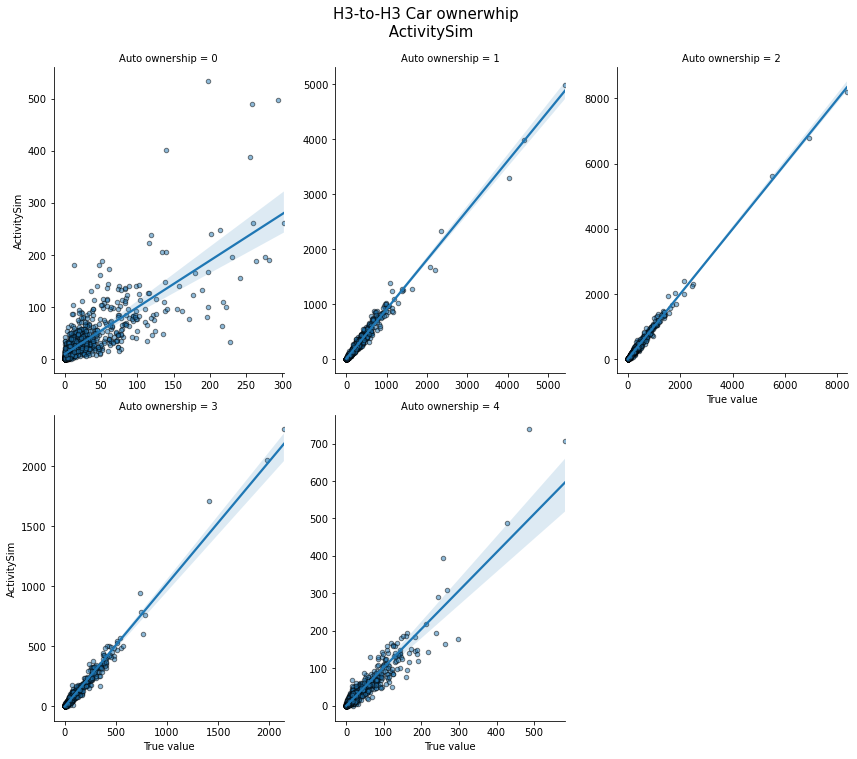

In [25]:
to_plot = car_ownership_validation(hh)

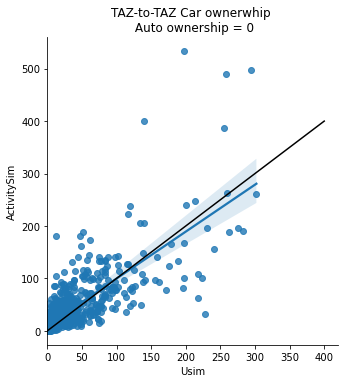

In [26]:
sns.lmplot('True value','ActivitySim',  to_plot[to_plot['Auto ownership']=='0'])

x = np.linspace(0,400,400)
plt.plot(x, x, color = 'black')
plt.title('TAZ-to-TAZ Car ownerwhip \n Auto ownership = 0')
plt.xlabel('Usim');